<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In [32]:
!nvidia-smi

Tue Jan  4 00:28:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |   8356MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [33]:
import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [34]:
!pip install -q tensorflow==2.3.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.13.3 requires google-cloud-bigquery[bqstorage,pandas]<2.0.0dev,>=1.11.1, but you have google-cloud-bigquery 2.31.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [35]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [36]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you have scipy 1.7.3 which is incompatible.
pandas-gbq 0.13.3 requires google-cloud-bigquery[bqstorage,pandas]<2.0.0dev,>=1.11.1, but you have google-cloud-bigquery 2.31.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is in

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [37]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [38]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression = 'zip',low_memory=False)
df.shape

(1306122, 3)

In [40]:
print(df.iloc[-40:,1:3])

                                             question_text  target
1306082  What return will be the approx returns for 10k...       0
1306083  Brazil’s meat exports hit by restrictions from...       0
1306084  I see daily many jobs are posted on various jo...       0
1306085  Difference between activity and statechart dia...       0
1306086              How do you create a BrainPOP account?       0
1306087  What different student groupings can teachers ...       0
1306088  We are preparing a proposal for a client whose...       0
1306089  I live in the UK. If I get diagnosed with depr...       0
1306090  Do you believe China can surpass the former So...       0
1306091  How is Trump funding rallies and advertising p...       0
1306092  I hardly talk about my interests (reading and ...       0
1306093  How is it to have intimate relation with your ...       1
1306094  Why is it when singers have lyrics about voice...       1
1306095     Does the ginger plant naturally contain sugar?    

<AxesSubplot:title={'center':'target distribution'}, ylabel='Frequency'>

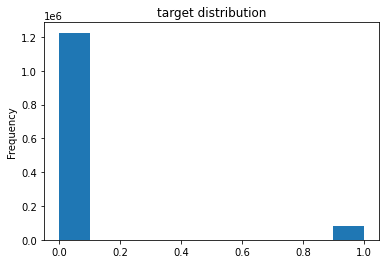

In [41]:
df.target.plot(kind='hist',title='target distribution')

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [42]:
train_df, ramaining = train_test_split(df,random_state = 42,train_size = 0.0075,stratify = df.target.values)
valid_df, _ = train_test_split(ramaining,random_state = 42,train_size = 0.00075,stratify = ramaining.target.values)

In [43]:
train_df.shape
valid_df.shape

(972, 3)

In [44]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values,valid_df['target'].values))
  

## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [45]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1]# Label categories
max_seq_length = 128# maximum length of (token) input sequences
batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',trainable = True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case)


In [46]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you happiness?')


['hi', '##,', 'how', 'are', 'you', 'happiness', '##?']

In [47]:
tokenizer.convert_tokens_to_ids(['[SEP]'])


[102]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [48]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,text_a=text.numpy(),text_b = None,label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
  return feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id 

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [49]:
def to_feature_map(text, label):
  input_ids, input_mask,segment_ids,label_id = tf.py_function(to_feature, inp = [text,label],Tout = [tf.int32,tf.int32,tf.int32,tf.int32])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_word_ids': input_ids, 'input_mask': input_mask, 'input_type_ids': segment_ids}
  return x,label_id

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [50]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32,drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32,drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE))

  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [51]:
# train data spec
train_data.element_spec


({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [52]:
# valid data spec
valid_data.element_spec


({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [53]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation='sigmoid',name = 'output')(drop)

  model = tf.keras.Model(inputs = {
                'input_word_ids' : input_word_ids,
                'input_mask' : input_mask,
                'input_type_ids' : input_type_ids
  }, 
  outputs = output)
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [54]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),loss = tf.keras.losses.BinaryCrossentropy(), metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

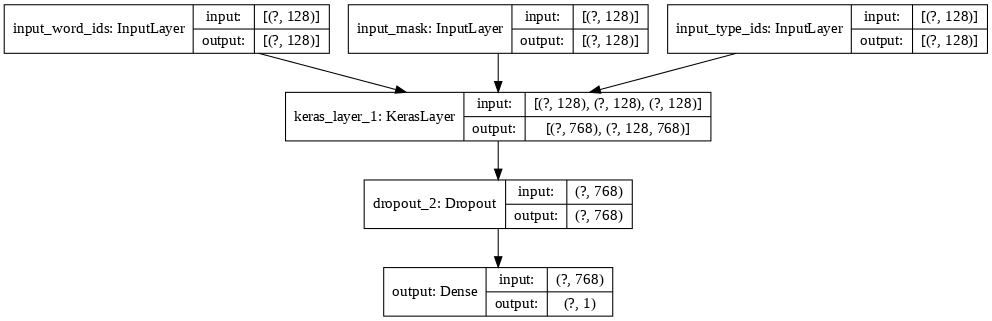

In [55]:
tf.keras.utils.plot_model(model=model,show_shapes = True, dpi = 76)

In [56]:
# Train model
history = model.fit(train_data, validation_data=valid_data, epochs = 2,verbose = 1)

Epoch 1/2
306/306 [==============================] - ETA: 0s - loss: 0.1678 - binary_accuracy: 0.9378WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_test_batch_end` time: 0.5087s). Check your callbacks.


306/306 [==============================] - 478s 2s/step - loss: 0.1678 - binary_accuracy: 0.9378 - val_loss: 0.1195 - val_binary_accuracy: 0.9531
Epoch 2/2
306/306 [==============================] - 477s 2s/step - loss: 0.0918 - binary_accuracy: 0.9638 - val_loss: 0.1728 - val_binary_accuracy: 0.9531


## Task 11: Evaluate the BERT Text Classification Model

In [57]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

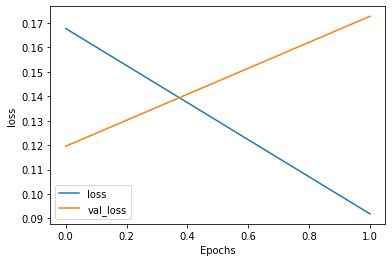

In [58]:
plot_graphs(history,'loss')

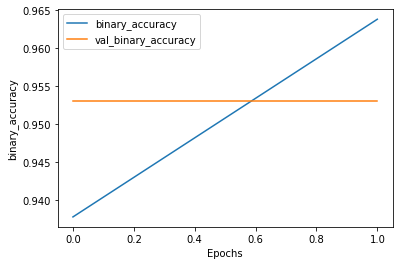

In [59]:
plot_graphs(history,'binary_accuracy')

In [144]:
sample_example = ["Why are you angry?",'why are you angry all the times?']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)


In [145]:
preds

array([[0.041254  ],
       [0.00250965]], dtype=float32)